In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
import pandas as pd

In [ ]:
traces_train=pd.read_pickle('dataset/integrators_data_train.pickle')
results_train=pd.read_pickle('dataset/integrators_outputs_train.pickle')

traces_test=pd.read_pickle('dataset/integrators_data_test.pickle')
results_test=pd.read_pickle('dataset/integrators_outputs_test.pickle')

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(output_size, 1)
        self.sig = nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.fc(output)
        output = self.sig(output)[0]
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
def train(trace,result,nn,learning_rate,loss_function):
    hidden = nn.initHidden()
    nn.zero_grad()
    for i in range(len(trace)):
        output, hidden = nn(trace[i], hidden)
    loss = loss_function(output, result)
    loss.backward()
    for p in nn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [5]:
n_iters = 10000
print_every = 500
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
loss_function = nn.BCELoss()
n_hidden = 10
rnn = RNN(traces_train[0].size(2),n_hidden,1)

In [ ]:
traces_train[0]

In [6]:
losses=[]
for iter in range(1, n_iters + 1):
    index = np.random.randint(len(traces_train))
    trace, result = traces_train[index], results_train[index]
    output, loss = train(trace,result,rnn,learning_rate,loss_function)
    losses.append(loss)
    if iter % print_every == 0:
        print(output, result, loss)

tensor([0.4985], grad_fn=<SelectBackward0>) tensor([1.]) 0.6960977911949158
tensor([0.2606], grad_fn=<SelectBackward0>) tensor([1.]) 1.3446882963180542
tensor([0.9924], grad_fn=<SelectBackward0>) tensor([1.]) 0.00763035798445344
tensor([1.6617e-05], grad_fn=<SelectBackward0>) tensor([0.]) 1.661716669332236e-05
tensor([1.1290e-05], grad_fn=<SelectBackward0>) tensor([0.]) 1.1289647773082834e-05
tensor([1.8314e-06], grad_fn=<SelectBackward0>) tensor([0.]) 1.8313664895686088e-06
tensor([1.0000], grad_fn=<SelectBackward0>) tensor([1.]) 3.3975225960602984e-05
tensor([0.9999], grad_fn=<SelectBackward0>) tensor([1.]) 6.115623546065763e-05
tensor([5.9118e-07], grad_fn=<SelectBackward0>) tensor([0.]) 5.911774678679649e-07
tensor([0.0002], grad_fn=<SelectBackward0>) tensor([0.]) 0.00022620598610956222
tensor([2.4855e-07], grad_fn=<SelectBackward0>) tensor([0.]) 2.4855000901879976e-07
tensor([7.5179e-05], grad_fn=<SelectBackward0>) tensor([0.]) 7.51818879507482e-05
tensor([1.0000], grad_fn=<Select

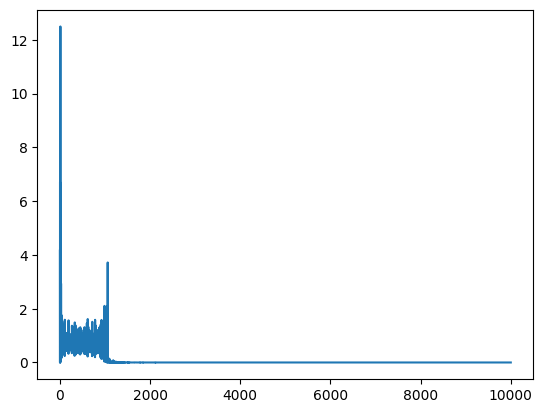

In [7]:
plt.plot(range(len(losses)),losses)

In [8]:
def evaluate(nn,trace,result):
  hidden = rnn.initHidden()
  for i in range(len(trace)):
      output, hidden = nn(trace[i], hidden)
      if output>0.5:
         output=1
      else:
         output=0
  return output==result

correct=0
for i in range(len(traces_test)):
  correct+=evaluate(rnn,traces_train[i],results_train[i])

print(correct/len(traces_test))

tensor([1.])
